In [1]:
""" Spreadsheet Column Printer
ce script permet de faire de la visualisation des données de corpus. On peut faire des graphiques pour visualiser 
la distribution des longueurs de documents, 
avoir la moyenne des longueurs de documents, 
la distribution des POS,
nuage de point,
lois de zipf
petite analyse des sentiments

après cela on peut utiliser le script metrique.ipynb

"""

' Spreadsheet Column Printer\nce script permet de faire de la visualisation des données de corpus. On peut faire des graphiques pour visualiser \nla distribution des longueurs de documents, \navoir la moyenne des longueurs de documents, \nla distribution des POS,\nnuage de point,\nlois de zipf\npetite analyse des sentiments\n\naprès cela on peut utiliser le script metrique.ipynb\n\n'

In [2]:
!pip install matplotlib

J'ai du ajouter la conversion de chaînes de caractères en listes de tokens pour que se fasse le calcul de longueur de document. 

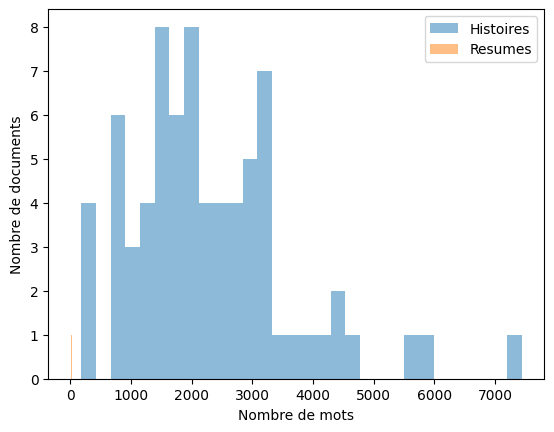

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# Chargement du DataFrame
df = pd.read_csv('../data/histoires_resumes_annotes.csv')

# Convertir les chaînes de caractères en listes de mots
df['h_tokens'] = df['h_annot'].apply(lambda x: x.split())
df['r_tokens'] = df['r_annot'].apply(lambda x: x.split())

# Création d'un histogramme des longueurs de document
histoires_lengths = df['h_tokens'].apply(len)
resumes_lengths = df['r_tokens'].apply(len)

plt.hist(histoires_lengths, bins=30, alpha=0.5, label='Histoires')
plt.hist(resumes_lengths, bins=30, alpha=0.5, label='Resumes')
plt.legend(loc='upper right')

# personnalisation du graphique
plt.xlabel('Nombre de mots')
plt.ylabel('Nombre de documents')

# si le dossier n'existe pas alors il se crée
if not os.path.exists('../figures'):
    os.makedirs('../figures')

# enregistrement graphique
plt.savefig('../figures/taille_documents.png')

plt.show()

# Création d'un nouveau DataFrame avec les longueurs
lengths_df = pd.DataFrame({
    'histoires_lengths': histoires_lengths,
    'resumes_lengths': resumes_lengths
})

# Enregistrement du DataFrame dans un fichier CSV
lengths_df.to_csv('../data/h_r_taille.csv', index=False)

Cet histogramme montre la distribution des longueurs de documents dans les histoires et les résumés que contient mon corpus. L'axe x représente le nombre de mot et l'axe y le nombre de documents ayant cette longueur. On peut constater que les résumés font tous bien moins de 1000 mots. Et que dans les récits, la plupart tournent autour de 2000 mots. 
Ci-dessous, j'ai calculé la moyenne du nombre de mots dans les histoires et les résumés. Les résumés ont une moyenne de 20 mots contre 2 278 pour les histoires. 

In [4]:
# moyenne du nombre de mots dans les résumés
r_moyenne_mot = resumes_lengths.mean()
# moyenne du nombre de mots dans les histoires
h_moyenne_mot = histoires_lengths.mean()

print("La moyenne du nombre de mots dans les résumés est :", r_moyenne_mot)
print("La moyenne du nombre de mots dans les histoires est :", h_moyenne_mot)


La moyenne du nombre de mots dans les résumés est : 19.71232876712329
La moyenne du nombre de mots dans les histoires est : 2277.5068493150684


Visualisation des différents tags POS utilisés dans les histoires et les résumés.

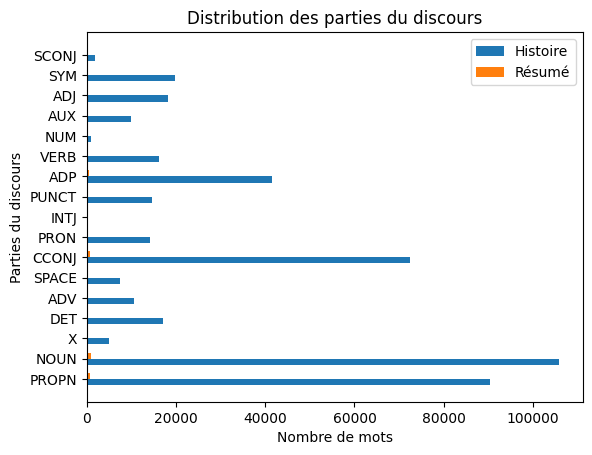

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import spacy

# Charger le modèle spaCy
nlp = spacy.load("fr_core_news_sm")

# Charger le fichier CSV
df = pd.read_csv('../data/histoires_resumes_annotes.csv')

# Fonction pour extraire les parties du discours
def get_pos_distribution(text):
    doc = nlp(text)
    pos_counts = Counter([token.pos_ for token in doc])
    return pos_counts

# appel de la fonction get_pos_distribution sur les histoires et les résumés
df['h_pos'] = df['h_annot'].apply(get_pos_distribution)
df['r_pos'] = df['r_annot'].apply(get_pos_distribution)

# Somme des distributions
histoire_pos_total = sum(df['h_pos'], Counter())
resumes_pos_total = sum(df['r_pos'], Counter())

# Récupération de tous les POS qui apparaissent dans les 2 colonnes
all_pos_tags = set(histoire_pos_total.keys()).union(set(resumes_pos_total.keys()))

# comptage
histoire_counts = [histoire_pos_total.get(pos, 0) for pos in all_pos_tags]
resumes_counts = [resumes_pos_total.get(pos, 0) for pos in all_pos_tags]

# résultat
y = range(len(all_pos_tags))

# définition de la largeur des barres
width = 0.3

fig, ax = plt.subplots()
ax.barh(y, histoire_counts, width, label='Histoire')
ax.barh([p + width for p in y], resumes_counts, width, label='Résumé')

ax.set_ylabel('Parties du discours')
ax.set_xlabel('Nombre de mots')
ax.set_title('Distribution des parties du discours')
ax.set_yticks([p + width/2 for p in y])
ax.set_yticklabels(all_pos_tags)
ax.legend()

# enregistrement graphique
plt.savefig('../figures/distribution_pos.png')
plt.show()

on constate que les mots les plus fréquents dans les histoires sont:
des noms : plus de 100000 mots
pronoms(propn) : plus de 80 000 mots
conjonctions de coordination (CCONJ) entre 60K et 80k mots
et prépositions (ADP) : entre 40k et 60k mots.

Comparé aux fréquences de mots dans les résumés, qui au total ne dépasse pas même les 10k mots. On aperçoit que les noms sont la catégorie la plus représentée, tandis que les conjonctions de coordination et les prépositions se valent.


In [6]:
!pip install wordcloud

Création de 2 nuages de mots, un pour les histoires et l'autre pour les résumés.

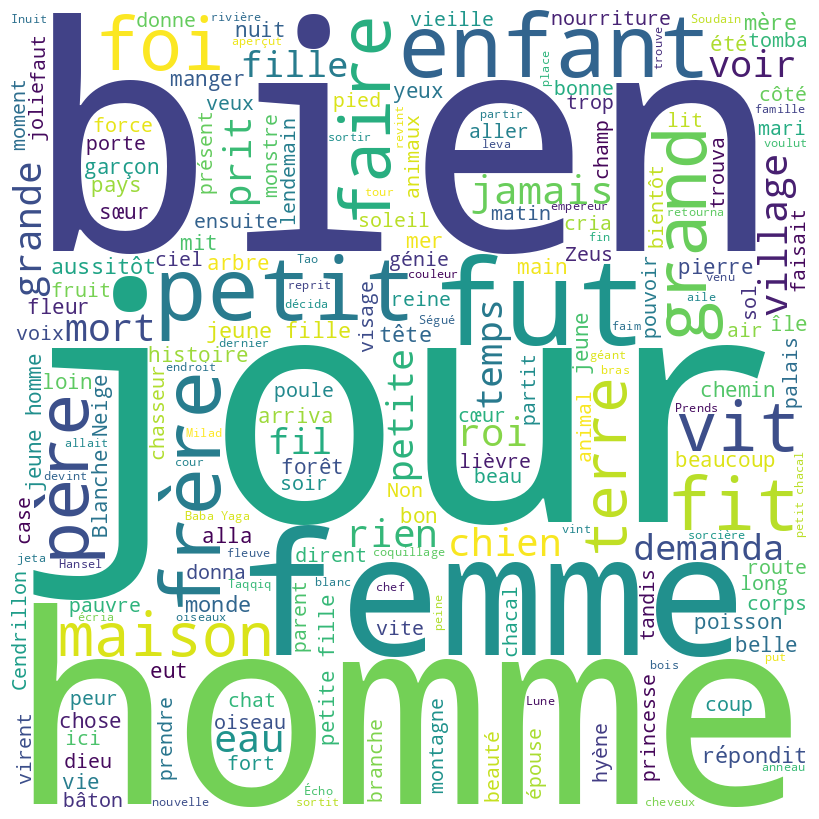

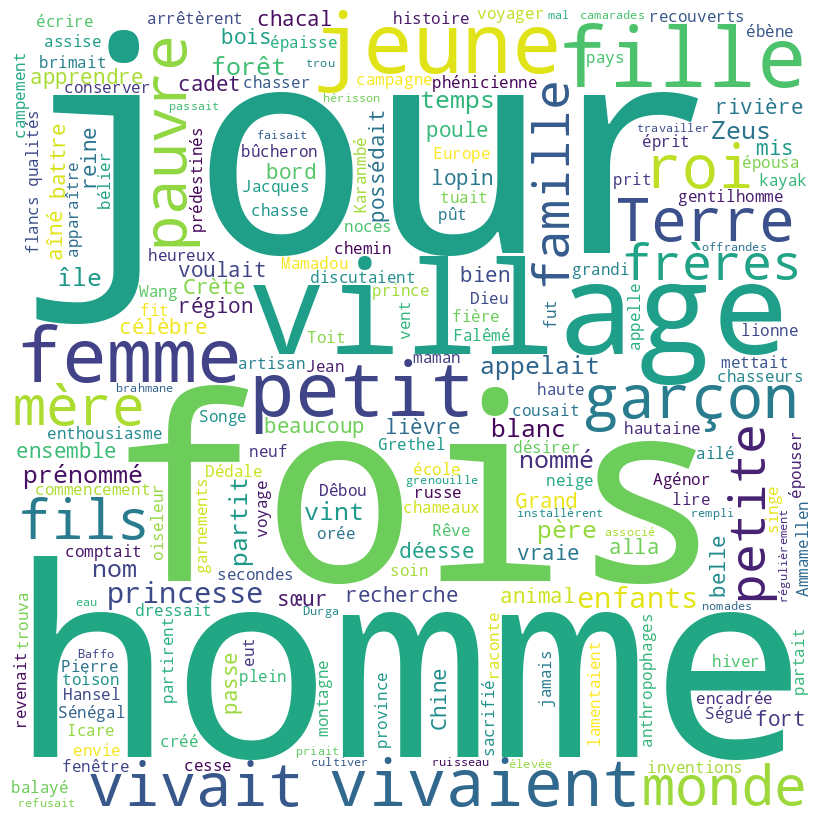

In [7]:
from wordcloud import WordCloud

df = pd.read_csv('../data/histoires_resumes.csv')

# Fonction pour extraire les mots, sans les stopwords, les chiffres et sans les ponctuations
def recup_words(text):
    """ Parametres
        text : str
    
        Return
        list of words
    """
    doc = nlp(text)
    words = []
    for token in doc:
        if not token.is_stop and not token.is_punct and token.text.isalpha():
            words.append(token.text)    
    return words

# appel de la fonction
df['h_words'] = df['histoire'].apply(recup_words)
df['r_words'] = df['resumes'].apply(recup_words)

# Somme des mots
histoire_words_total = ' '.join(sum(df['h_words'], []))
resumes_words_total = ' '.join(sum(df['r_words'], []))

# création des nuages de mots
wordcloud_histoire = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate(histoire_words_total)

wordcloud_resume = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate(resumes_words_total)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_histoire) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

#enregistrement nuage1
plt.savefig('../figures/nuage_mot_histoire.png')  
plt.show()

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_resume) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

#enregistrement nuage 2

plt.savefig('../figures/nuage_mot_resume.png')

plt.show()

In [8]:
!pip install textblob

In [9]:
from textblob import TextBlob

df = pd.read_csv('../data/histoires_resumes.csv')

# fonction pour calculer les sentiments
def get_sentiment(text):
    """ Parametres
        text : str
    
        Return
        stat of polarity
    """
    blob = TextBlob(text)
    return blob.sentiment.polarity

# appel de la fonction
df['histoire_sentiment'] = df['histoire'].apply(get_sentiment)
df['resume_sentiment'] = df['resumes'].apply(get_sentiment)


# affichage du DataFrame
print(df.head())

   id                                           histoire  \
0   1    Ammamellen avait une sœur et, toutes les foi...   
1   2    Un jeune homme du nom de Mamadou, qui voulai...   
2   3    Des hommes étaient en voyage. En chemin, ils...   
3   4    Dans un village de la campagne russe vivait ...   
4   5    Il était une fois une famille pauvre qui com...   

                                             resumes  histoire_sentiment  \
0  Ammamellen avait une sœur et, toutes les fois ...            0.162857   
1  Un jeune homme du nom de Mamadou, qui voulait ...            0.265208   
2  Des hommes étaient en voyage. En chemin, ils s...            0.150000   
3  Dans un village de la campagne russe vivait un...            0.284356   
4  Il était une fois une famille pauvre qui compt...            0.681380   

   resume_sentiment  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0  


Plus le score de sentiment se rapproche de 0, plus il est négatif et plus il se rapproche de 1, plus il est positif.
Les résumés des histoires étant trop court, le calcul de sentiment ne renvoit donc pas de résultat exploitable pour faire une visualisation graphique intéressante.

sentiment_category
Négatif    45
Neutre     17
Positif    11
Name: count, dtype: int64


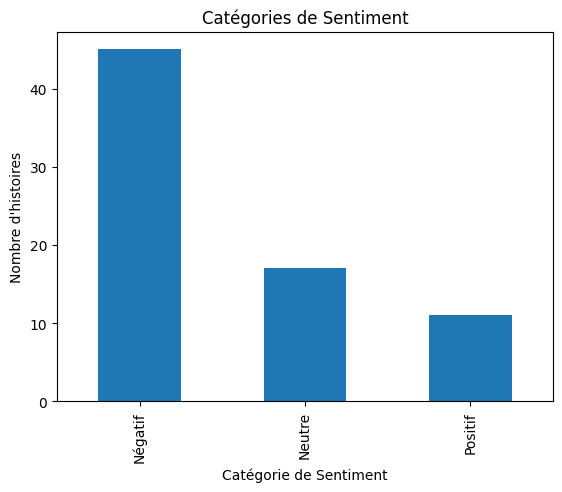

In [10]:
def categorize_sentiment(score):
    """ Parametres
        score : float
    
        Return
        sentiment category
    """
    if score > 0.6:
        return 'Positif'
    elif score < 0.4:
        return 'Négatif'
    else:
        return 'Neutre'

df['sentiment_category'] = df['histoire_sentiment'].apply(categorize_sentiment)

# compter combien il y a d'histoire par catégorie
category_counts = df['sentiment_category'].value_counts()
print(category_counts)

# Visualisation des catégories de sentiment
category_counts.plot(kind='bar')
plt.title('Catégories de Sentiment')
plt.xlabel('Catégorie de Sentiment')
plt.ylabel('Nombre d\'histoires')

df.to_csv('../data/histoires_resumes_sentiment.csv', index=False)
#enregistrement classement par catégorie de sentiment
plt.savefig('../figures/categorie_sentiment.png')
plt.show()

La visualisation des catégorie de sentiment permet de voir que les histoires racontées aux enfants ont tendance à être plus négatives. 

Loi de zipf

In [11]:
!pip install dataset

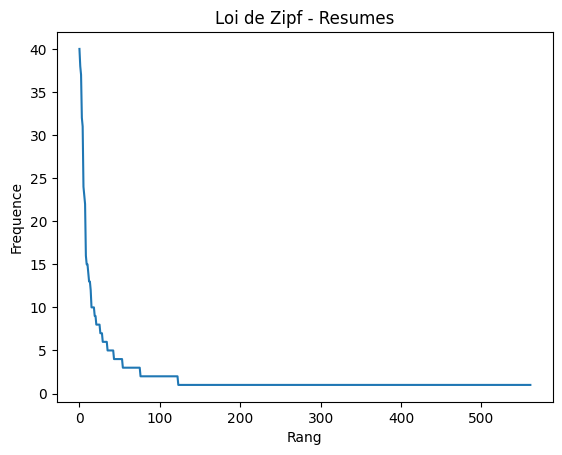

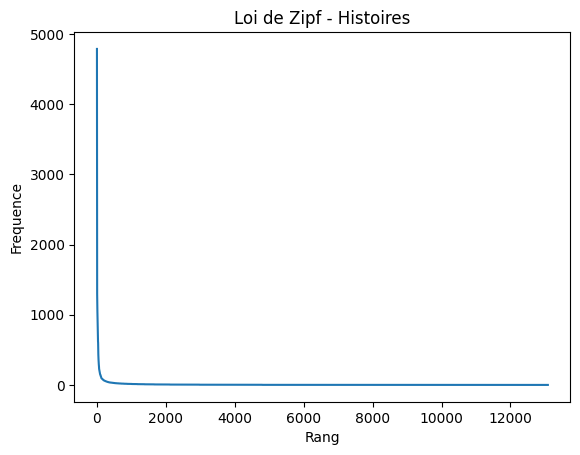

In [12]:
def split_tokens(text):
    """ Parametres
        text : str
    
        Return
        splited text
    """
    return text.split()

# Chargement du DataFrame
df = pd.read_csv('../data/histoires_resumes.csv')

df['h_tokens'] = df['histoire'].apply(split_tokens)
df['r_tokens'] = df['resumes'].apply(split_tokens)

# Pour les résumés
concat_context = []
for i, element in enumerate(df['r_tokens']):
    for token in element:
        concat_context.append(str(token))
    if i>200:
        break

concat_context_counter = Counter(concat_context)
plt.plot(sorted(concat_context_counter.values(), reverse=True))
plt.title('Loi de Zipf - Resumes')
plt.xlabel('Rang')
plt.ylabel('Frequence')
#enregistrement loi 1
plt.savefig('../figures/loizipf_resume.png') 
plt.show()

# Pour les histoires
concat_context = []
for i, element in enumerate(df['h_tokens']):
    for token in element:
        concat_context.append(str(token))
    if i>200:
        break

concat_context_counter = Counter(concat_context)
plt.plot(sorted(concat_context_counter.values(), reverse=True))
plt.title('Loi de Zipf - Histoires')
#enregistrement loi 2
plt.savefig('../figures/loizipf_histoire.png') 
plt.xlabel('Rang')
plt.ylabel('Frequence')
plt.show()

La loi de Zipf est une loi empirique qui permet de visualiser la fréquence des mots dans un corpus face à leur place dans le rang de la liste de fréquence.
Dans le graphique 1, on peut voir que la ligne diminue rapidement pour les mots les plus souvent utilisé. On voit un léger ralentissement dans la courbe des résumés, là où se forme un "escalier". A cette endroit les mots semblent avoir un nombre d'utilisation assez ressemblant. Puis la courbe diminue à nouveau pour rester droite jusq'au bout, dans cette ligne droite se trouve les mots les moins fréquents, aussi appelé "hapax", qui normalement n'apparaitront qu'une seule fois. 

Le graphique des histoires montre une courbe plus lisse que la courbe des résumés, et beaucoup plus élevés en terme de fréquence de mots. Il semblerait qu'un mot soit utilisé entre 4600 à 5000 fois. Puis la ligne descend de façon rapide, jusqu'à la fréquence de 1, de là la plupart des mots ne sont utilisés qu'une fois, il n'y a pas de forme d'escalier comme sur le premeir graphique. Le graphique 2 semble montrer qu'il y a environ 12 000 mots qui sont utilisés entre 0 et 500 fois.